In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from skipper import tiling
from astropy import coordinates
from skipper import observe, visualize

### Define COSMOS region

In [3]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
#cosmos_area = geometry.Polygon ( edges )

### Create object that generates COSMOS dithering pattern

In [4]:
frd = tiling.FocusedRandomDither (center, random_max=0.1, offset_radius=0.01, ndither=40)

In [5]:
#frd._make_grid ()
#poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )
centers = frd.get_centers ()

Text(0, 0.5, 'Dec (deg)')

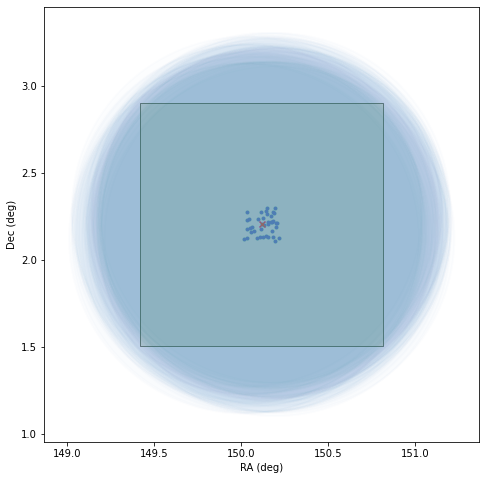

In [6]:
# \\ Visualize the dithering pattern
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(frd.ndither):
    patch = patches.Circle ( centers[ij], radius=frd.fov_radius, fc='C0', ec='tab:blue', lw=2, alpha=0.01)
    ax.add_patch(patch)
    ax.scatter(*centers[ij], color='C0', marker='.')
ax.scatter ( *frd.center, color='r', marker='x')

ax.set_xlim ( center.ra.deg - 1.25,  center.ra.deg  + 1.25)
ax.set_ylim ( center.dec.deg- 1.25,  center.dec.deg + 1.25)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')

### Build Observing Catalog and plan nights

In [21]:
# \\ Build observing catalog, and take a quick look
ocat = observe.ObsCatalog(comment='--', proposer='LeathaudGreene', propid='2020B-0288')
catalog = ocat.build_catalog(centers[:,0], centers[:,1], 'COSMOS', 'N708', 'object', 10.*60)
catalog.head()

,comment,filter,seqtot,seqnum,seqid,expType,object,proposer,program,RA,propid,dec,expTime,count
0,--,N708,40,1,TEST,object,COSMOS,LeathaudGreene,Merian,150.119167,2020B-0288,2.205833,600.0,1
1,--,N708,40,2,TEST,object,COSMOS,LeathaudGreene,Merian,150.035239,2020B-0288,2.232619,600.0,1
2,--,N708,40,3,TEST,object,COSMOS,LeathaudGreene,Merian,150.057844,2020B-0288,2.163092,600.0,1
3,--,N708,40,4,TEST,object,COSMOS,LeathaudGreene,Merian,150.158266,2020B-0288,2.207272,600.0,1
4,--,N708,40,5,TEST,object,COSMOS,LeathaudGreene,Merian,150.174983,2020B-0288,2.255762,600.0,1


In [8]:
g09 = pd.read_csv('../json/g09_new.csv', index_col=0)

In [9]:
g09.head()

,comment,filter,seqtot,seqnum,expType,object,proposer,program,RA,propid,dec,expTime
0,--,N708,168,1,science,G09,LeathaudGreene,Merian,129.498929,2020B-XXXX,-0.318037,600.0
1,--,N708,168,2,science,G09,LeathaudGreene,Merian,129.790240,2020B-XXXX,-0.373307,600.0
2,--,N708,168,3,science,G09,LeathaudGreene,Merian,130.084376,2020B-XXXX,-0.407801,600.0
3,--,N708,168,4,science,G09,LeathaudGreene,Merian,130.378489,2020B-XXXX,-0.442677,600.0
4,--,N708,168,5,science,G09,LeathaudGreene,Merian,131.079919,2020B-XXXX,-0.328560,600.0


In [10]:
mastercat = pd.concat([g09,catalog])
mastercat.index = np.arange(mastercat.index.size)

/Users/kadofong/env3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
# \\ Define the observatory site -- default is CTIO
ctio = observe.ObservingSite ()
priorities = {'COSMOS':0}

In [12]:
fmt = '%Y/%m/%d %I:%M %p'

In [13]:
nights = np.arange(5,18,1)
nights = np.concatenate([nights[:7], nights[8:]])
nights

array([ 5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17])

In [20]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 2, 25 )
obs_end = obs_start + 0.5*(twibeg-obs_start)

ocat.plan_night ( obs_start, ctio, catalog=catalog, obs_end=obs_end,
                    maxairmass=1.5, object_priority=priorities )

2021-02-26 04:00:00
==> 20210226_00
0.0s filled by priority=0.0 objects
==> 20210226_01
0.0s filled by priority=0.0 objects
==> 20210226_02
3600.0s filled by priority=0.0 objects
==> 20210226_03
3600.0s filled by priority=0.0 objects
==> 20210226_04
(180s) Not enough time for an exposure. Skipping...


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,is_queued,qstamp,has_priority,airmass
0,False,,0.0,NaN
1,False,,0.0,NaN
2,True,20210226_02,0.0,1.449922031281158
3,False,,0.0,NaN
4,False,,0.0,NaN
5,True,20210226_02,0.0,1.449839750311677
6,False,,0.0,NaN
7,True,20210226_03,0.0,1.2596968166979519
8,False,,0.0,NaN
9,True,20210226_03,0.0,1.2597357940658607


In [14]:
obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, nights[0] )
obs_end = obs_start + 0.5*(twibeg-obs_start)

print(obs_start.astimezone(ctio.timezone).strftime(fmt))
print(obs_end.astimezone(ctio.timezone).strftime(fmt))

is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                             maxairmass=1.5, object_priority=priorities )

for night in nights[1:]:
    obs_start, twibeg = ctio.get_sunriseset ( 2021, 3, night)
    obs_end = obs_start + 0.5*(twibeg-obs_start)

    print(obs_start.astimezone(ctio.timezone).strftime(fmt))
    print(obs_end.astimezone(ctio.timezone).strftime(fmt))

    is_queued = ocat.plan_night ( obs_start, ctio, catalog=mastercat, obs_end=obs_end,
                                 maxairmass=1.5, is_queued=is_queued )

2021/03/05 09:00 PM
2021/03/06 01:57 AM
2021-03-06 04:00:00
==> 20210306_00
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210306_01
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects


/Users/kadofong/env3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


==> 20210306_02
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210306_03
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210306_04
(180s) Not enough time for an exposure. Skipping...
2021/03/06 08:54 PM
2021/03/07 01:54 AM
2021-03-07 04:00:00
==> 20210306_23
(360s) Not enough time for an exposure. Skipping...
==> 20210307_00
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210307_01
0.0s filled by priority=0.0 objects
3600.0s filled by priority=inf objects
==> 20210307_02
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210307_03
3600.0s filled by priority=0.0 objects
0.0s filled by priority=inf objects
==> 20210307_04
(360s) Not enough time for an exposure. Skipping...
2021/03/07 08:54 PM
2021/03/08 01:54 AM
2021-03-08 04:00:00
==> 20210307_23
(360s) Not enough time for an exposure. Skipping...
==> 20210308_00
0.0s filled by priority=0.0 objects
3600.0s fi

Text(0, 0.5, 'N')

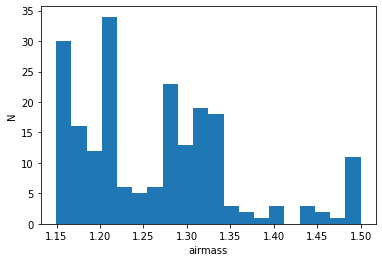

In [91]:
plt.hist(is_queued['airmass'].astype(float), bins=20)
plt.xlabel('airmass')
plt.ylabel('N')

In [38]:
is_queued.sort_values('qstamp', ascending=False)

,is_queued,qstamp,has_priority
167,True,20210316_02,inf
166,True,20210316_02,inf
165,True,20210316_02,inf
164,True,20210316_02,inf
159,True,20210316_02,inf
146,True,20210316_01,inf
158,True,20210316_01,inf
145,True,20210316_01,inf
144,True,20210316_01,inf
156,True,20210316_01,inf


In [61]:
assert is_queued.query('has_priority==0.')['is_queued'].all()

# Visualize queued pointings

In [62]:
from shapely import geometry
from descartes.patch import PolygonPatch
from astropy import units as u

In [63]:
g09edges = np.loadtxt('../data/g09edge.dat')
poly_g09 = geometry.Polygon(g09edges)  
print('The GAMA09 field area is: ' + str(poly_g09.area))
print('Fraction of the entire Merian Survey is: '+str(100*poly_g09.area/800))

The GAMA09 field area is: 140.6957220611181
Fraction of the entire Merian Survey is: 17.58696525763976


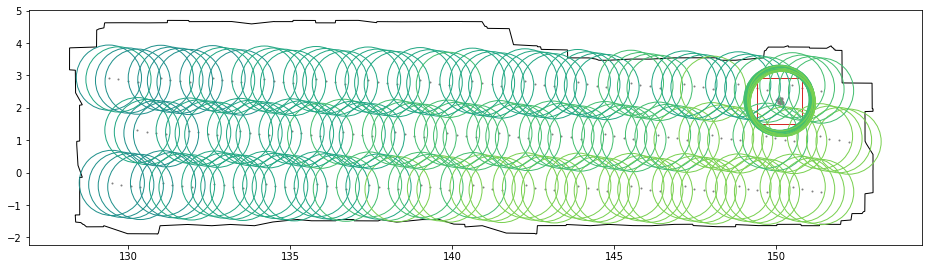

In [64]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,16))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

for name,row in tq.iterrows():
    timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')
    if timestamp.hour>12:
        hr = timestamp.hour - 24.
    else:
        hr = timestamp.hour
    patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                            fc='None')
    
    ax.add_patch(patch)
        
ax.scatter(tq.RA, tq.dec, s=1, color='grey')

In [81]:
is_queued.sort_values('qstamp')

,is_queued,qstamp,has_priority,airmass
0,True,20210306_00,inf,1.4342565856335472
1,True,20210306_00,inf,1.4386870119509114
2,True,20210306_00,inf,1.4436128599153988
3,True,20210306_00,inf,1.448603756402121
4,True,20210306_00,inf,1.4644684770606595
5,True,20210306_00,inf,1.4692636553268135
10,True,20210306_00,inf,1.490293317923787
11,True,20210306_00,inf,1.4957051929677003
12,True,20210306_00,inf,1.4955793419836068
28,True,20210306_01,inf,1.2844797039872582


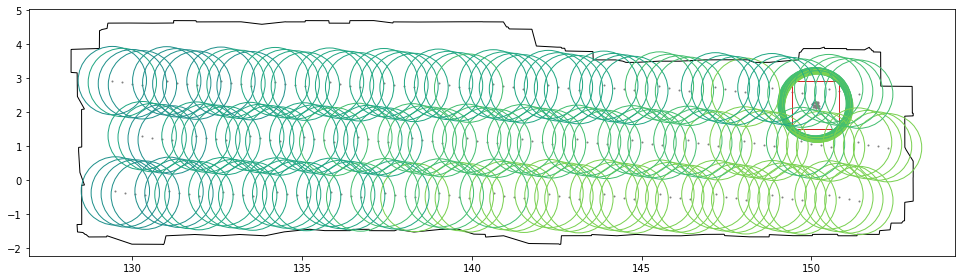

In [90]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,4))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

ax.scatter(tq.RA, tq.dec, s=1, color='grey')

frame=0
for name,qrow in is_queued.sort_values('qstamp').iterrows():
    row = tq.loc[name]
    timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')

    if timestamp.day > (night+1):
        continue
    if timestamp.hour>12:
        hr = timestamp.hour - 24.
    else:
        hr = timestamp.hour
    patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                            fc='None')

    ax.add_patch(patch)
    plt.tight_layout ()
    plt.savefig(f'../../figures/anim/{frame:05d}.png')
    frame+=1

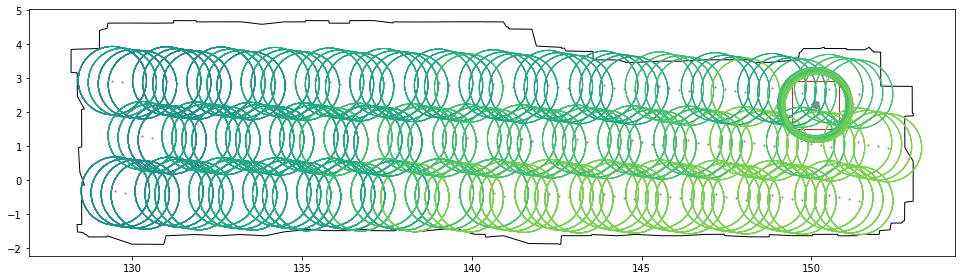

In [89]:
tq = mastercat.loc[is_queued.is_queued]
fov_radius = (3.18/np.pi)**0.5
plt.figure(figsize=(16,4))
ax = plt.subplot(111, aspect='equal')
patch1 = PolygonPatch(poly_g09, edgecolor='k',facecolor='none',lw=1)
ax.add_patch(patch1)

cosmos = patches.Rectangle ( ((center.ra - size[0]/2.*u.deg).value, 
                              (center.dec - size[1]/2.*u.deg).value),
                             *size, fc='None', ec='tab:red')
ax.add_patch(cosmos)

ax.scatter(tq.RA, tq.dec, s=1, color='grey')

for night in nights:
    for name,row in tq.iterrows():
        timestamp = datetime.datetime.strptime (is_queued.loc[name,'qstamp'], '%Y%m%d_%H')

        if timestamp.day > (night+1):
            continue
        if timestamp.hour>12:
            hr = timestamp.hour - 24.
        else:
            hr = timestamp.hour
        patch = patches.Circle ( (row.RA, row.dec), fov_radius, ec=plt.cm.viridis((hr+5)/10.), 
                                fc='None')

        ax.add_patch(patch)
    plt.tight_layout ()
    plt.savefig(f'../../figures/anim/night{int(night):02d}.png')
